# Introduction to Cross-Validation

-----

When constructing models to describe data, a natural inclination is to increase the model complexity in order to make the model more accurate. While this approach might result in a model that accurately predicts the training data, this approach can result in [**overfitting**][wof], in which a model fits the signal and the noise (or error) in the training data. This has two primary issues. First, the model will most likely not generalize to new data where the noise (or errors) is different. Second, and most important, the performance of the model on the training data can give false confidence, and real world performance will be reduced, potentially much reduced.

In this notebook, we explore the concept of overfitting. We first build a simple data set, and learn how a model can underfit or overfit this data, by varying the complexity of the model (in this case we use linear regression to fit different order polynomial functions to the data). Next, we introduce the concept of [**cross-validation**][wcv] to mitigate the possibility of overfitting when training a model. Finally, we introduce validation and learning curves, which provide insight into model construction as the training features and data change.

-----

[wof]: https://en.wikipedia.org/wiki/Overfitting
[wcv]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)

## Table of Contents

[Formalism](#Formalism)
- [Validation Curve](#Validation-Curve)

[Cross Validation](#Cross Validation)

- [KFold](#KFold)
- [Leave One Out](#Leave-One-Out)
- [Leave P Out](#Leave-P-Out)
- [Shuffle Split](#Shuffle-Split)
- [Stratified KFold](#Stratified-KFold)
- [Group KFold](#Group-KFold)

[Validation Curves](#Validation-Curves)

[Learning Curves](#Learning-Curves)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default seaborn plotting style
sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

One of the primary tasks a data analyst must accomplish is to effectively model a data set. The reason this task is so important is that a good model both enables a deeper investigation into the process generating the data, and enables predictions to be made. These benefits disappear, however, if the model is not a good representation of the actual data. Thus, you will often spend a considerable amount of time tuning and testing models.

There are two competing issues when fitting a model to data. First, we want to effectively capture the underlying signal in the data. Second, we want to avoid capturing the noise (or error) in the data. If we fail to capture the signal, we have underfit the data, which is known as a bias error. On the other hand, if we model the noise, we have overfit the data, which is known as a variance error. This leads to the [bias-variance tradeoff][wbvt], where we must find the model that is complex enough to capture the signal, but not too complex that it has captured the noise in the training data.

To demonstrate this concept, the following Code cells first generate a signal data set and a random noise data set.  The noise is controlled in large part by the `sigma` parameter, changing this up or down will increase or decrease the noise (or error) in the data. The second Code cell plots the resulting signal, plus sampled data that we will later split into training and testing data. Later Code cells will fit models of different complexity to the training data in order to visually demonstrate underfitting and overfitting.

-----
[wbvt]: https://en.wikipedia.org/wiki/Bias–variance_tradeoff

In [2]:
# Define random state for notebook
rng = np.random.RandomState(23)

# We define a simple function to fit.
def theModel(xmin=0.01, xmax = 9.99, num=100):
    
    # Noise scale
    sigma = 0.75

    # Sample points
    x = np.linspace(xmin, xmax, num)
    
    # Define signal and noise arrays
    signal = 25. - np.sqrt(x) * np.cos(x) - np.sqrt(x)
    noise = sigma * rng.randn(len(x))
    
    return(x, signal, noise)

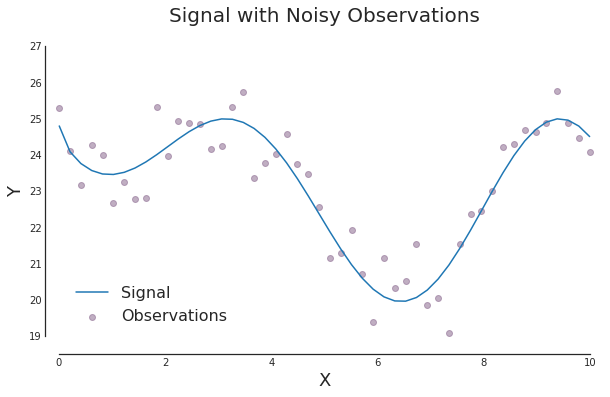

In [3]:
# Make data
x, s, n = theModel(num = 50)

# Create figure area
fig, axs = plt.subplots(figsize=(10, 6))

# Plot signal and observations points
axs.plot(x, s, label='Signal')
axs.scatter(x, s + n, c=sns.xkcd_rgb["dusty purple"],
            alpha=0.5, label='Observations')

# Dcorate plot
axs.set(title='Signal with Noisy Observations',
       xlabel='X', xlim=(-0.25, 10.25),
       ylabel='Y', ylim=(18.5, 27.5))
axs.legend(loc=3, borderaxespad=1.5)
sns.despine(offset=0, trim=True)

-----

We can employ the [`PolynomialFeatures`][skpf] estimator from the scikit learn library to transform a data set into values that can be used by a linear regression estimator. Formally, this process creates a new feature matrix, where the new values are created by raising the original features to the indicated polynomial orders. Thus, if we have one feature that consists of integers, the new features would be these integers raised to the power 0, 1, 2, 3, etc., up to the order of the polynomial. This approach allows a regular linear regression to be performed that actually computes the best fitting polynomial over these new features.

We demonstrate this in the following Code cell, where we create a `PolynomialFeatures` estimator and fit this estimator to an empty array to initialize it (we could use other data here). Next, we display the polynomial terms (showing the full fifth order polynomial), and  use this estimator to transform the number two into the appropriate polynomial features (which is just `2` raised to the powers: 0, 1, 2, 3, 4, and 5).

-----

[skpf]: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# Create fake data
x_sample = np.zeros(20).reshape(20, 1)

# Create polynomial feature
pp = PolynomialFeatures(5).fit(x_sample)
print('Polynomial terms:', pp.get_feature_names())

# Display polynomial transformation
print(pp.transform(2))

Polynomial terms: ['1', 'x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5']
[[  1.   2.   4.   8.  16.  32.]]


-----

In the following Code cell, we fit low and high-order polynomial functions to these data by generating the new feature matrix from the input data in order to visually demonstrate underfitting and overfitting. These two figures show the original signal (in light purple), the training data (small blue circles), the testing data (large red circles), as well as several specific model fits.

In the case of underfitting, the model fails to capture the inherent signal in the data. This is demonstrated in the first figure, where the first and third order fits do not closely resemble the underlying signal (the light purple curve). On the other hand, overfitting is where the model captures both the signal and the noise fluctuations (and will thus fail to generalize to new, unseen data). This is demonstrated in the second figure where the nineteenth and twenty-fourth order polynomials capture most of the original signal (the light purple curve), but also display odd behavior, particularly at either end. For example, at the high end, there are excess fluctuations, where the model is trying to capture the noise in the model.

In general, you will not be able to visually represent this behavior so easily. With a small, controlled data set, however, the contrast between fitting the bias (or signal) and the variance (or noise) can be easily demonstrated. Given sufficiently large data sets, we often do not need to be concerned with underfitting, since we can always increase model complexity. On the other hand, overfitting should always be a concern for any data scientist (or analyst), and we must always remain vigilant to prevent it from occurring and impacting our predictions.

-----

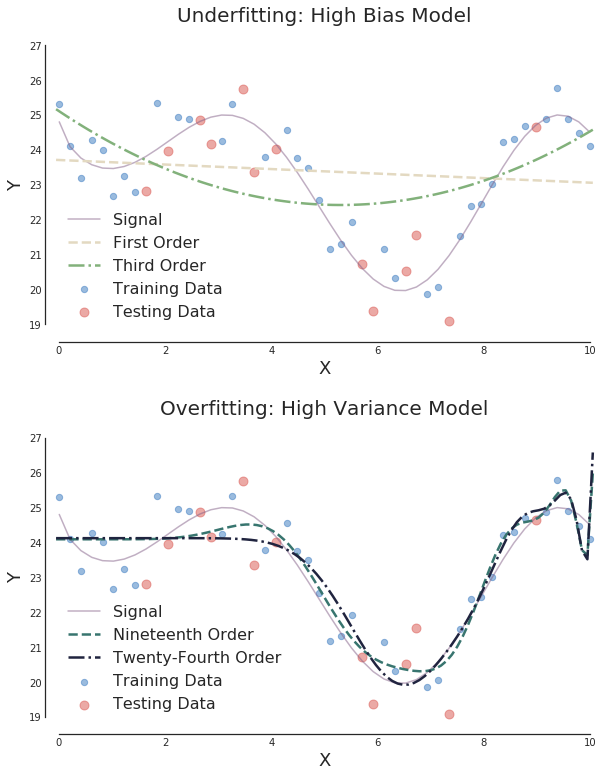

In [5]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import make_pipeline as mp
from sklearn.model_selection import train_test_split

# Define observation array
y = s + n

# Set the training fraction and maximum degree of polynomical fit
test_frac = 0.25

# Ready data set for cross-validation
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=test_frac, random_state=23)

num_figs = 2

# Create figure area
fig, axs = plt.subplots(figsize=(10, 1 + 6 * num_figs), 
                        nrows=num_figs, ncols=1, sharex=False)
plt.subplots_adjust(hspace=0.25)

# Polynomial degrees
degs = [1, 2, 19, 24]

# Define colormap for polynomial fits
cmp = sns.cubehelix_palette(len(degs), start=.25, rot=-.75)

# Define label list
lbls = ['First', 'Third', 'Nineteenth', 'Twenty-Fourth']

# Define linestyle list
lst = ['--', '-.', '--', '-.']

# Sample predict points
xf = np.linspace(-0.05, 10.05, 100)

for idx in range(num_figs):

    # Plot signal
    axs[idx].plot(x, s, c=sns.xkcd_rgb['dusty purple'], 
                  alpha=0.5, linestyle='-',
                  label='Signal')

    # Plot training and testing data
    ax = sns.regplot(x_train, y_train, ax=axs[idx], fit_reg=False, 
                     color=sns.xkcd_rgb["windows blue"], 
                     scatter_kws={'alpha':0.5, 's':40},
                     label="Training Data")
    
    ax = sns.regplot(x_test, y_test, ax=axs[idx], fit_reg=False, 
                     color=sns.xkcd_rgb["pale red"], 
                     scatter_kws={'alpha':0.5, 's':80},
                     label="Testing Data")

# Iterate over polynomial fits
for idx, deg in enumerate(degs):
    
    # Create pipeline for fit, and train regressor
    est = mp(PolynomialFeatures(deg, include_bias=True), 
             LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)

    # Low order fits on first plot, others to second plot
    if deg < 5:
        ax = axs[0]
    else:
        ax = axs[1]
        
    # Plot predicted points
    ax.plot(xf, est.predict(xf[:, np.newaxis]),
            c=cmp[idx], linestyle=lst[idx], lw=2.5,
            label=f'{lbls[idx]} Order')

ttls = ['Underfitting: High Bias Model', 
        'Overfitting: High Variance Model']

for idx in range(num_figs):
    # Decorate plot
    axs[idx].set(title=ttls[idx],
                 xlabel='X', xlim=(-0.25, 10.25),
                 ylabel='Y', ylim=(18.5, 27.5))
    axs[idx].legend(loc=3, borderaxespad=1.0)
    sns.despine(ax=axs[idx], offset=0, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

### Validation Curve

We can explore the relationship between model complexity and model performance by using a validation curve. To make this figure, we first create different models that vary in their complexity, for example, by varying one specific hyperparameter. Next, we apply these models to both the training and validation (or testing) data. For each model, we compute the performance score, for example, the $R^2$ score. Thus, we end up with measures of model complexity versus model performance, which we display by using a validation curve. 

The following figure demonstrates this concept by using the $R^2$ performance score when we fit different polynomial orders to our sample data. To produce this result, the following Code cell iterates over different models, in this case the model complexity is encoded simply by the polynomial order. We use a pipeline to combine a `PolynomialFeatures` with a `LinearRegression`. Next, we fit this pipeline to the training data (generated earlier) and compute the performance of the model on both the training and testing data. The rest of the code simply plots these data for comparison. 

In this case, we see that the model underfits both the training and testing data for small polynomial fits. As the polynomial order increases, the training data, and later the testing data, show significant improvements. Eventually, however, the performance on the testing data deviates away from the performance on the training data, indicating that the model has begun to overfit (since the model is no longer generalizing to the test data). Eventually both curves drop, indicating that the model has become too complex for the limited training data. Thus, this curve indicates that the best fits to our data will arise from polynomial fits with order between five and around twenty. 

In general, we prefer simpler models (in the absence of reasons to do otherwise), thus we would likely do best with a fifth-order polynomial for these data. This last point follows [Occam’s Razor][wor], which can be summarized as _all other things being equal, simpler explanations are preferred to more complex ones_. This both helps prevent overfitting and also produces models that are easier to interpret or explain.

----

[wor]: https://en.wikipedia.org/wiki/Occam%27s_razor

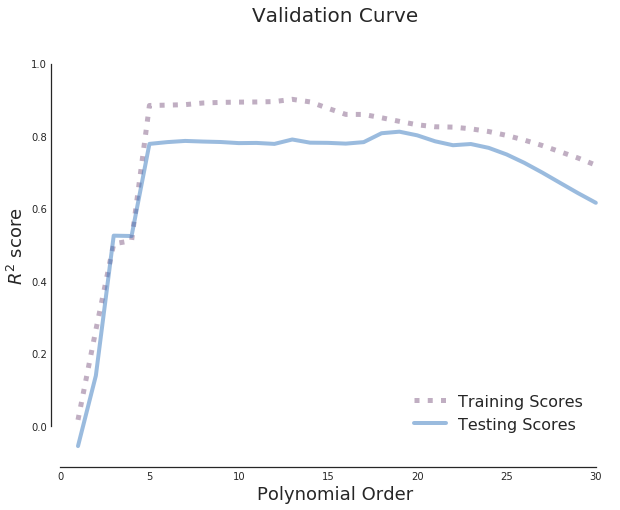

In [6]:
from sklearn.metrics import r2_score

# We compute the maximum degree of polynomial regression
# as 85% of the number of training data points. This is
# simply a rough heuristic
max_deg = int(0.85 * len(x) * (1 - test_frac))
degs = range(1, max_deg)

# Training and testing score lists
trs = [] ; tes = []

# Regress each polynomial model on the data
for idx, deg in enumerate(degs):
    
    # Create pipeline for fit, and train regressor
    est = mp(PolynomialFeatures(deg, include_bias=True), LinearRegression())
    est.fit(x_train[:, np.newaxis], y_train)
    
    # Append training and testing r^2 scores
    trs.append(r2_score(y_train, est.predict(x_train[:, np.newaxis])))
    tes.append(r2_score(y_test, est.predict(x_test[:, np.newaxis])))

# Create figure area
fig, axs = plt.subplots(figsize=(10, 8))

# Plot training scores
axs.plot(degs, trs, c=sns.xkcd_rgb["dusty purple"],
         alpha=0.5, lw=5, linestyle=':',
         label='Training Scores')

# Plot testing scores
axs.plot(degs, tes, c=sns.xkcd_rgb["windows blue"],
         alpha=0.5, lw=4, linestyle='-',
         label='Testing Scores')

# Decorate plot
axs.set(title='Validation Curve',
        xlabel='Polynomial Order', xlim=(-0.25, max_deg),
        ylabel=r'$R^2$ score', ylim=(-0.1, 1.1))
    
axs.legend(loc=4, borderaxespad=1.5)
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Cross Validation

We have repeatedly discussed in other notebooks the importance of using a separate training and testing set to ascertain the performance of a model. Relying simply on the performance of a model on the data on which it was trained will almost never generalize to new, unseen data. Thus, standard practice requires that we train the model on the training data and test the performance of the model on the unseen test data. However, if we change the hyperparameters of a model, and use the performance of the different resulting models on the test data to determine the best hyperparameters, we run the risk of once again having a model that fails to generalize to new, unseen data. Formally, this latter issue is known as leakage, since the information contained in the test data _leaks_ into the model selection process.

One option to circumvent this issue would be to divide the training data into three chunks. The first data set would be used for training, the second data set would be used for validating the model hyperparameters, and the final data set would be used for testing the final model performance. In this approach, this last data set is the only data that would be used to report the performance of the final model. The challenge with this idea is two-fold. First, splitting potentially precious training data into three chunks reduces the amount of **true** training data we have for the model, thus our model may fail to adequately capture the desired signal. Second, our model might become sensitive to fluctuations in the random subset of the data used for training (especially if the training data is small).

A second, and preferred option, is to divide the data into multiple segments, or **folds**, hold one segment out for model validation, and use the other folds for training. We can repeat the training and validating by iterating through the folds, so that we use all data for training and validating. By statistically combining these model predictions, we can determine the best hyperparameters. This approach is known as [**cross-validation**][wcv]. While we still need to hold a separate data set out from this process to test the final model, cross-validation uses all of the remaining data to build and validate the final model.

There are multiple different cross-validation methods that can aid in selecting the optimal model or model hyperparameters for a given data set beyond a simple train/test splitting. Formally for these techniques to be appropriate, the data of interest must be independent and identically distributed (shortened to i.i.d. or IID). This means that the data are not dependent on each other (and are thus independent observations) and they all must be generated from the same probability distribution function. In practice, these technique often work fine (especially for large data sets), but if the data have natural groupings (or dependencies), this extra information can be used to produce more appropriate cross-validation samples.

Assuming our data are IID, The scikit learn library provides several [cross-validation iterators][skcvi]:
- `KFold` splits the data into k _folds_, trains on  $k - 1$ folds, and validates on the remaining fold.
- `StratifiedKFold` similar to `KFold`, but preserves the relative ratio of labelled classes within each fold.
- `GroupKFold` similar to `KFold`, but limits the testing data to only one group within each fold.
- `LeaveOneOut` iteratively leaves one observation out to validate the model trained on the remaining data.
- `LeavePOut` iteratively leaves $P$ observations out to validate the model trained on the remaining data.
- `ShuffleSplit` generates a user defined number of train/validate data sets, by first randomly shuffling the data.

These different cross-validation techniques are demonstrated in the following set of Code cells. First, we create a ten element array to demonstrate how these different techniques generate training and validating data set. Note, in this case, we generate data with only one feature (a numerical value zero through nine, inclusive), but these results extend to multi-feature data sets. In addition, these cross-validation techniques are implemented as iterators, which enables them to be used in loops to create the training and testing data sets, that can subsequently be processed efficiently inside the body of the _for_ loop.

-----
[wcv]: https://en.wikipedia.org/wiki/Cross-validation_(statistics)
[skcvi]: http://scikit-learn.org/stable/modules/cross_validation.html

In [7]:
# We create a ten element data array to demonstrate
# cross-validation
data = np.arange(10)
print(f'{data}')

[0 1 2 3 4 5 6 7 8 9]


-----

[[Back to TOC]](#Table-of-Contents)

### KFold

One of the most popular cross-validation techniques is k-fold cross-validation. This technique is implemented in the scikit learn library in the [`KFold`][skkf] iterator. This technique generates $k$ samples by splitting the original data into training and testing samples. If there are $n$ data values, the testing samples will contain  $n/k$ values. This is demonstrated in the following Code cell, where we apply k-fold cross-validation to a ten element array. In this case, $k=5$, which results in two elements in the training samples. Note that the testing samples are all distinct, which allows for more accurate test scores.

-----
[skkf]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [8]:
from sklearn.model_selection import KFold

# Create cross-validation iterator
kf = KFold(n_splits=5, random_state=23)

# Compute and display results
print('Train\t\t\t  Test')
print(30*'-')
for train, test in kf.split(data):
    print(f'{train}        {test}')

Train			  Test
------------------------------
[2 3 4 5 6 7 8 9]        [0 1]
[0 1 4 5 6 7 8 9]        [2 3]
[0 1 2 3 6 7 8 9]        [4 5]
[0 1 2 3 4 5 8 9]        [6 7]
[0 1 2 3 4 5 6 7]        [8 9]


-----

[[Back to TOC]](#Table-of-Contents)

### Leave One Out


The simplest cross-validation technique to understand is the leave one out technique, which is implemented in the scikit learn library by the [`LeaveOneOut`][skloo] iterator. This technique iteratively holds one data value from the input data set out for testing, while the others are used for training. Thus, if we have ten data values, we will end up with ten samples, which each have nine values for training and one for testing. 

The following Code cell demonstrates this cross-validation technique, where we divide the original ten element array into ten samples, where one value is held out for testing and nine are used for training.

-----

[skloo]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html

In [9]:
from sklearn.model_selection import LeaveOneOut

# Create cross-validation iterator
loo = LeaveOneOut()

# Compute and display results
print('Train\t\t\t  Test')
print(30*'-')
for train, test in loo.split(data):
    print(f'{train}        {test}')

Train			  Test
------------------------------
[1 2 3 4 5 6 7 8 9]        [0]
[0 2 3 4 5 6 7 8 9]        [1]
[0 1 3 4 5 6 7 8 9]        [2]
[0 1 2 4 5 6 7 8 9]        [3]
[0 1 2 3 5 6 7 8 9]        [4]
[0 1 2 3 4 6 7 8 9]        [5]
[0 1 2 3 4 5 7 8 9]        [6]
[0 1 2 3 4 5 6 8 9]        [7]
[0 1 2 3 4 5 6 7 9]        [8]
[0 1 2 3 4 5 6 7 8]        [9]


-----

[[Back to TOC]](#Table-of-Contents)

### Leave P Out

We can extend the leave one out cross-validation technique to leave multiple items out. Note, however, that this can generate a very large number of splits. This technique is implemented in the scikit learn library in the [`LeavePOut`][sklpo] iterator. Given $n$ data points, selecting $p$ items to leave out is a combinatorial problem:

$$
{n \choose p}= \frac{n!}{p! (n - p)!}
$$

For example, when n = 10, and p = 2, we have forty-five different splits that can be created. This cross-validation technique is demonstrated in the following Code cell, where to limit the output we select splits from only the first half of our data array. This results in only ten splits, which will more easily fit in this notebook. 

Notice how the training data clearly follow the combinatorial process, the first value is selected, and the second one iterates through the remaining combinations. Next, the first value is incremented, and the process continues until no new, unique splits can be created.

-----
[sklpo]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html

In [10]:
from sklearn.model_selection import LeavePOut

# Create cross-validation iterator
lpo = LeavePOut(p=2)

# Compute and display results
print('Train\t\tTest')
print(20*'-')

# We only use first five values in our data array to limit output
for train, test in lpo.split(data[:5]):
    print(f'{train}        {test}')

Train		Test
--------------------
[2 3 4]        [0 1]
[1 3 4]        [0 2]
[1 2 4]        [0 3]
[1 2 3]        [0 4]
[0 3 4]        [1 2]
[0 2 4]        [1 3]
[0 2 3]        [1 4]
[0 1 4]        [2 3]
[0 1 3]        [2 4]
[0 1 2]        [3 4]


-----

[[Back to TOC]](#Table-of-Contents)

### Shuffle Split

The last type of standard cross-validation we will explore is shuffle split cross-validation, implemented in the scikit learn library by the [`ShuffleSplit`][skss] iterator. This form of cross-validation first randomly shuffles the data, and then splits the data into the training and testing samples. This provides an extra degree of randomness, since data can appear in a training or testing set more times than with the other cross-validation techniques. This is demonstrated in the following Code cell, where we create ten samples with 80% of the data used for training from our original numerical sample. If equally divided, each number should appear in the test data twice, but the output indicates numbers can occur once, twice, and even three times.

-----
[skss]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html

In [11]:
from sklearn.model_selection import ShuffleSplit

# Create cross-validation iterator
ss = ShuffleSplit(n_splits=10, test_size=0.2, random_state=23)

# Display results
print('\tTrain\t\tTest')
print(30*'-')
for train, test in ss.split(data):
    print(f'{train}      {test}')

	Train		Test
------------------------------
[2 9 4 7 1 0 6 3]      [5 8]
[8 2 1 4 5 9 6 3]      [0 7]
[4 3 6 2 1 9 5 0]      [7 8]
[2 5 3 8 9 1 4 7]      [0 6]
[0 7 4 8 2 1 6 3]      [9 5]
[4 2 5 0 8 7 9 6]      [1 3]
[1 5 9 7 2 6 0 3]      [4 8]
[0 8 4 5 3 2 9 7]      [6 1]
[5 2 8 6 1 3 4 0]      [9 7]
[6 4 3 0 2 1 7 8]      [5 9]


-----

[[Back to TOC]](#Table-of-Contents)

### Stratified KFold

When the training data are imbalanced, we need to be careful when dividing the data into training and testing data sets, so that class balance is preserved in both training and testing. Otherwise, the resulting model will perform poorly in the testing process (or even worse, on new unseen data). In this case, we must employ stratified sampling, which attempts to preserve class balance in the training and testing data sets. The scikit learn module provides several stratified cross-validation techniques including:
- [`StratifiedKFold`][skskf], and 
- [`StratifiedShuffleSplit`][sksss].

The next Code cell demonstrates `StratifiedKFold`, where we reuse the original numeric data, but add in randomly selected class labels (either 0 or 1). These labels are used to stratify the training and testing data in K folds to maintain class balance, as demonstrated in the output.

-----
[skskf]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
[sksss]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [12]:
from sklearn.model_selection import StratifiedKFold

print(f'Data:  {data}')

# Generate random class labels (0 or 1)
cls = rng.choice(2, 10)
print(f'Class: {cls}\n')

# Create cross-validation iterator
skf = StratifiedKFold(n_splits=4, random_state=23)

# Display cross-validation results
print('\tTrain\t\tTest')
print(30*'-')
for train, test in skf.split(data, cls):
    print(f'{train}        {test}')

Data:  [0 1 2 3 4 5 6 7 8 9]
Class: [1 0 0 0 1 0 0 1 1 1]

	Train		Test
------------------------------
[3 5 6 7 8 9]        [0 1 2 4]
[0 1 2 4 5 6 8 9]        [3 7]
[0 1 2 3 4 6 7 9]        [5 8]
[0 1 2 3 4 5 7 8]        [6 9]


-----

[[Back to TOC]](#Table-of-Contents)

### Group KFold

In some cases, data are naturally grouped such that we wish to train on some groups and apply to other groups. For example, we might have data that have a natural grouping, such as data collected from different runs using the same equipment, or that were done by  different laboratories. Likewise, if the data are not independent, we can look for a natural grouping that would enable cross-validation to be utilized. In these cases, we need a different cross-validation technique that maintains the group structure such that groups do not span training and testing data. These techniques are known as group-wise cross-validators. The scikit learn library provides group-wise versions of the main cross-validation techniques, including:
- [`GroupKFold`][skgkf], 
- [`LeaveOneGroupOut`][skloo],
- [`LeavePGroupsOut`][sklpo], and
- [`GroupShuffleSplit`][skgss].

We demonstrate one of these techniques, `GroupKFold` in the following Code cell. In this example, we start with the original numerical data analyzed in previous Code cells, and add random groups [10, 11, or 12]. Note, since we might occasionally get fewer than three groups in this random process (which would throw a Python exception) on a ten element data array, we increase the number of data elements for this Code cell to fifteen. The `GroupKFold` technique selects one group for the testing, and uses the other two groups for training. With three groups, we would train three different models, whose scores could be combined together by computing the mean and standard deviation.

-----
[skgkf]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
[skloo]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html
[sklpo]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePGroupsOut.html
[skgss]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html

In [13]:
from sklearn.model_selection import GroupKFold

# Double data for this code cell only
data2 = np.arange(15)

print(f'Data:  {data2}')

num_grps = 3
# Generate random groups (10, 11, 12)
grps = rng.choice([10, 11, 12], 15)
print(f'Class: {grps}\n')

# Create cross-validation iterator
skf = GroupKFold(n_splits=num_grps)

# Display cross-validation results
print('\tTrain\t\t\t\tTest')
print(60*'-')
for train, test in skf.split(data2, groups=grps):
    print(f'{train}             {test}')

Data:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Class: [10 12 10 10 10 12 10 10 12 10 12 11 11 12 11]

	Train				Test
------------------------------------------------------------
[ 1  5  8 10 11 12 13 14]             [0 2 3 4 6 7 9]
[ 0  2  3  4  6  7  9 11 12 14]             [ 1  5  8 10 13]
[ 0  1  2  3  4  5  6  7  8  9 10 13]             [11 12 14]


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we demonstrated different cross-validation techniques. Now that you have run the previous cells, try making changes to the notebook and see if you can predict the results.

1. Change the original data array to contain only odd integers between 1 and 21. How do the folds in the `KFold` cross-validation technique change?
2. Try implementing the `StratifiedShuffleSplit` cross-validation technique on the original data vector (and provided class array).
2. Try implementing the `GroupShuffleSplit` cross-validation technique on the new data vector (and provided class array).

-----

[[Back to TOC]](#Table-of-Contents)

## Validation Curves

Earlier in this Notebook, we computed the validation curve for the original linear regression model (using the polynomial expansion of our feature matrix). This plot nicely demonstrates the performance of an algorithm as a parameter is varied. The scikit learn library provides the [`validation_curve`][skvc] object, which is a direct mechanism for computing the data necessary for this plot. In this section, we explore the use of cross-validation to score models and to generate a validation curve. 

The first Code cell below imports the handwritten digit data set. This data set is comprised of 1797 instances, which are each 8 by 8 pixel images of handwritten digits. Thus, each instance has 64 features (one feature per pixel). 

-----

[skvc]: http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
[sklc]: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

In [14]:
import sklearn.datasets as ds

# Load the Digits Data
digits = ds.load_digits()
    
# Now lets get the data and labels
x = digits.data
y = digits.target

-----

Cross-validation is not only important in selecting among different models, but is also important for selecting optimal model parameters, as demonstrated in the following Code cells.  The first Code cell creates a pipeline to normalize the handwritten digit data set before applying a support vector classification estimator. To perform cross validation, we use the special `cross_val_score` method, which takes an estimator and performs cross validation using the supplied cross validation technique to the supplied data. In the first example, we specify that five-fold should be used (note, the default when a classification estimator is used is a stratified k-fold cross-validation, in this case $k=5$).

This method will return, in this case, five performance scores, one for each fold in the cross-validation. We can take the mean and standard deviation of these scores to compute a more robust model score, along with an error estimate. The second Code cell demonstrates how the scoring metric can be changed, in this case the weighted `f1` score is used since we have a multi-class classification example (the digits data has ten classes). Finally, the third Code cell demonstrates how a specific cross-validation technique can be employed. In this case a shuffle split cross-validation with four folds, and twenty-five percent of the data held out for testing is used. In all cases, the final model accuracy is high with small scatter.

-----

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Build pipeline and ocmpute cross-validation score
msp = Pipeline([('ss', StandardScaler()),('svc', SVC(random_state=23))])
scores = cross_val_score(msp, x, y, cv=5)

# Compute and display results
print(scores)
print(f'{np.mean(scores):5.3f} +/- {np.std(scores):5.3f}')

[ 0.96153846  0.92541436  0.94428969  0.95238095  0.94084507]
0.945 +/- 0.012


-----

The cross-validation scoring function can also accept [different scoring functions][skme] (or even multiple functions). The following Code cell demonstrates how the `scoring` parameter to the `cross-val_score` function can be used to indicate a different scoring technique. In this particular case, the `f1_weighted` metric is used. This metric will generate a class-weighted **f1** score for the cross-validation samples.

-----
[skme]: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [16]:
# Change scoring metric
from sklearn.metrics import f1_score

# This is a multiclass classification (ten classes)
# so we must average the per class results
scores = cross_val_score(msp, x, y, cv=5, scoring='f1_weighted')

# Compute and display results
print(scores)
print(f'{np.mean(scores):5.3f} +/- {np.std(scores):5.3f}')

[ 0.96149855  0.92474732  0.94370083  0.95441727  0.94024287]
0.945 +/- 0.013


-----

The last parameter we may wish to change is the type of cross-validation to perform on the data. By default, KFold cross validation is used, but as discussed earlier, a number of other techniques are available that may be more appropriate for a given situation. We specify a different cross-validation technique by setting the `cv` parameter to the desired cross-validation iterator. In the following Code cell, we first create a `ShuffleSplit` cross-validation iterator, and use this iterator to generate cross-validation scores for these data.

-----

In [17]:
# Change cross-validation to a shuffle split
sscv = ShuffleSplit(n_splits=4, test_size=0.25, random_state=23)

# Compute cross-validation score
scores = cross_val_score(msp, x, y, cv=sscv)

# Compute and display results
print(scores)
print(f'{np.mean(scores):5.3f} +/- {np.std(scores):5.3f}')

[ 0.98666667  0.98222222  0.96222222  0.98222222]
0.978 +/- 0.009


-----

Of course there are three types of data used to score machine learning algorithms:

1. Training Data
2. Validation Data
3. Testing Data

Training data provides an upper bound on the expected performance of an algorithm, but since it is used to train the model, it is biased and should never be quoted as the **actual** performance of an algorithm. Validation data can also be used to predict the performance of an algorithm, but since an algorithm can still see validation data (during the cross-validation process), these data can also produce biased results. Testing data, on the other hand, should always be unseen by the algorithm during training, and thus are the best data to use to quantify the predictive power of an algorithm. 

The scikit learn [`validation_curve`][skvc] implementation displays both the training data score and the validation data score. The performance of an algorithm will, of course, vary as the quantity of training data are varied. Thus, a useful visual is the performance of an algorithm on training and validation data for a fixed set of parameters, as a function of the size of the training data. Note that if both the training and validation scores are low, the model will be underfitting the data. On the other hand, if the training score is high and the validation score is low, the model will be overfitting. The goal is for both scores to be high. Note, however, that the validation score should generally be below the training score.

Note, the computation of the data for a validation curve (and for the learning curve discussed later in this notebook) can take a while, since many different computations are performed (for each training/validation sample size and for each step in the cross validation process). Thus, in practice, we often start with a small set of hyperparameter values to get the right range before computing the scores over a larger set of hyperparameters to make the plot.

In the figure below, we see that for very small values of the $\gamma$ hyperparameter, the model underfits the data. Eventually, however, both the training and validation scores increase. In the middle of the figure, we have good performance, indicating these are good values for the $\gamma$ hyperparameter. Eventually, the validation score drops, while the training score remains high, indicating our model has overfit the training data. This figure indicates, therefore, that the optimal value of $\gamma$ is between 0.01 and 0.1.

-----

[skvc]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html

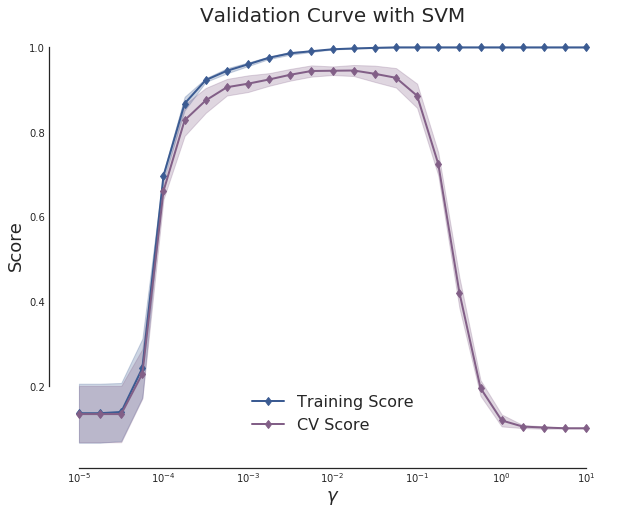

In [18]:
from sklearn.model_selection import validation_curve
from helper_code import vlcurves

param_range = np.logspace(-5, 1, 25)

trn_scr, tst_scr = validation_curve(msp, x, y, 
                                    param_name="svc__gamma", param_range=param_range, 
                                    cv=5, scoring="accuracy")

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(param_range, trn_scr, tst_scr)

# Plot the results
fig, ax = plt.subplots(figsize=(10,8))

# Plot data and ranges
trn_color = sns.xkcd_rgb["denim blue"]
ax.semilogx(param_range, y1, label="Training Score", 
            marker='d', lw=2, color=trn_color)
ax.fill_between(param_range, y1h, y1l, alpha=0.25, color=trn_color)

tst_color = sns.xkcd_rgb["dusty purple"]
ax.semilogx(param_range, y2, label="CV Score", 
            marker='d', lw=2, color=tst_color)
ax.fill_between(param_range, y2h, y2l, alpha=0.25, color=tst_color)

# Decorate plot
ax.set(title='Validation Curve with SVM',
        xlabel='$\gamma$',
        ylabel='Score')

ax.legend(loc='best', borderaxespad=1.5)
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Learning Curves

The validation curve provided insight into the selection of the optimal hyperparameter value by comparing the training and validation scores as the hyperparameter was varied. Another concept that we can explore is the minimum number of training samples we should obtain to achieve the best model performance. This second curve is known as a _learning curve_ and is implemented in scikit learn by the [`learning_curve`][sklc] function. Generally, a learning curve shows a convergence in the performance of an estimator on the training and validation data sets. In this manner, we gain insight into understanding the optimal size of a training data set for a given estimator. 

This curve also provides insight into whether a model is affected more by bias error or variance-error. For example, if the training score is much higher than the validation score, more training data could help generalize the model (since we are likely seeing the effects of fluctuations in the training data). If both scores are lower, we likely need a more complex model to capture the full signal (since our model fails to capture the full signal in the data).

In the next Code cell, we compute and display the learning curve for support vector classification applied to these data. For this estimator, we see that with small training data sets, the model underfits (since the scores are low). In this case, increasing the size of the training data quickly produces convergence to a high accuracy. At around fifty percent of the data used for training, the results stabilize and we see little improvement in either the training score or the validation score. This would indicate that adding additional training data is unlikely to improve the performance of this algorithm.

-----
[sklc]: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

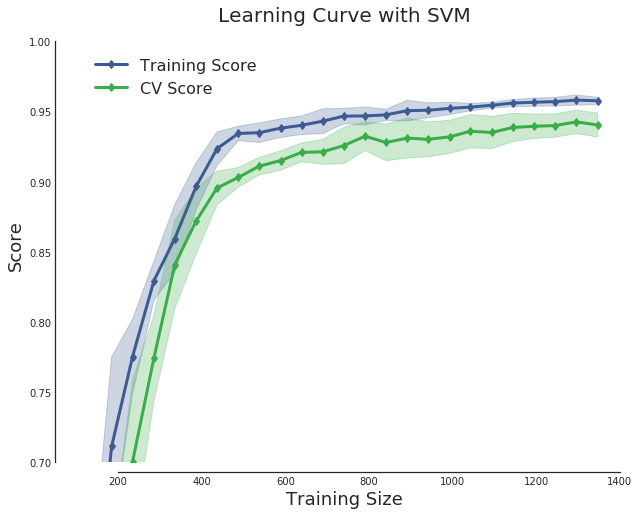

In [19]:
from sklearn.model_selection import learning_curve

# Construct training sizes
trn_sz=np.linspace(0.1, 1, 25)

cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=23)

# Build a pipeline to scale and classify data
svp = Pipeline([('ss', StandardScaler()),('svc', SVC(random_state=23))])
svp.set_params(svc__gamma=0.001)

# Generate learning curve
trn_szs, trn_scr, vld_scr = \
    learning_curve(svp, x, y, cv=cv, train_sizes=trn_sz)

# Compute plot range
y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(trn_szs, trn_scr, vld_scr)

# Plot curves
title = 'Learning Curve with SVM'
vlcurves.lv_plot(title, trn_szs, y1, y1h, y1l, 
                 y2, y2h, y2l, 'Training Size', 'Score', ylim=(0.7, 1.01))

-----

We can also construct learning curves for other machine learning estimators, which can be useful for both understanding the performance of the new estimator, as well as comparing the performance of different estimators. In the following Code cell, we demonstrate constructing a learning curve for a logistic regression estimator on these same _digits_ data. In this case, the training data provide high accuracy, even with small training samples, before slowly converging to a slightly lower accuracy. 

The cross-validation data, on the other hand, starts with a low accuracy before increasing to a higher accuracy. In this case, it would appear the model overfits initially, given the very high training data score, before eventually becoming more robust. This is not an uncommon result, as it is easy to overfit to small data sets, and as the training size increases the noise fluctuations have less impact on the model.

-----

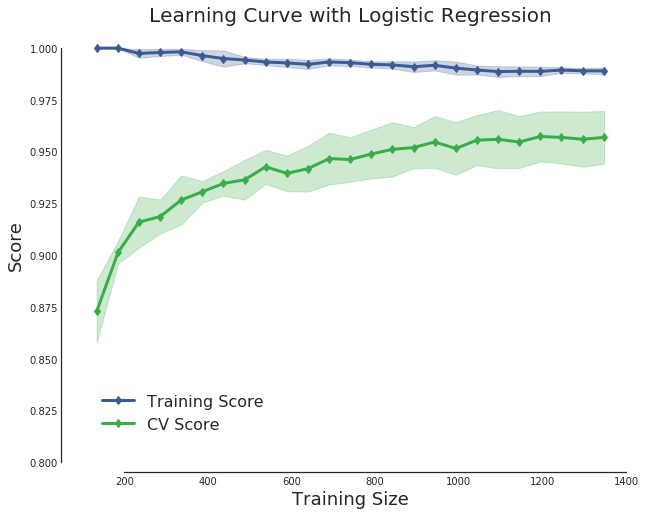

In [20]:
from sklearn.linear_model import LogisticRegression

# Employ a shuffle split cross validation
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=23)

# Construct training sizes
trn_sz=np.linspace(0.1, 1, 25)

# Build a pipeline to scale and classify data
lrp = Pipeline([('ss', StandardScaler()), 
                ('lr', LogisticRegression(random_state=23))])

# Generate learning curve
trn_szs, trn_scr, vld_scr = \
    learning_curve(lrp, x, y, cv=cv, train_sizes=trn_sz)

# Compute plot range
y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(trn_szs, trn_scr, vld_scr)

# Plot curves
title = 'Learning Curve with Logistic Regression'
vlcurves.lv_plot(title, trn_szs, y1, y1h, y1l, 
                 y2, y2h, y2l, 'Training Size', 'Score', ylim=(0.8, 1.01))

-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used validation and learning curves to explore the performance of a classification algorithm on the Handwritten Digit data. Now that you have run the Notebook, go back and make the following changes to see how the results change.

1. Compute a validation curve for the `C` parameter. Does this curve resemble the previous plot we constructed by hand for this parameter?
2. Change the cross-validation technique in the last example from `ShuffleSplit` to `KFold` and then `StratifiedKFold`. How does this change the resulting figure?
3. Try changing the parameters in the SVC and NB classifiers. How does this change the resulting figure?
4. Try using a different classifier, for example, a decision tree, or k-nearest neighbor. How does this change the resulting figure?

-----

## Ancillary information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. A [nice demonstration][1] on underfitting and overfitting
1. A [discussion][2] on overfitting and underfitting at the machine learning mastery website
2. A [wiki article][3] discussing overfitting
12. A [blog article][4] on overfitting

-----

[1]: http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html
[2]: https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/
[3]: https://gerardnico.com/wiki/data_mining/overfitting
[4]: http://www.halfbakedmaker.org/blog/848

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode